Saved comparison CSV to AzureAI_4o-mini-2-withTraining_comparison_misclassified_tweets.csv


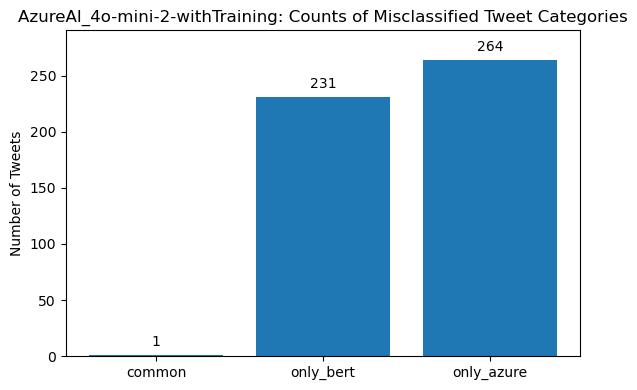

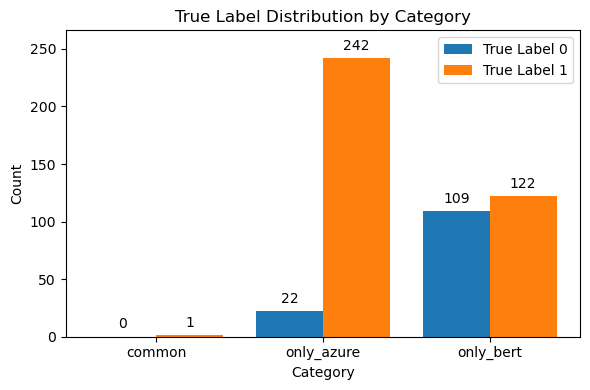

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Load the misclassified tweets
current_dir = os.path.basename(os.path.dirname(os.path.abspath("*")))
bert_path   = '../BERT_misclassified_tweets.csv'
azure_path  = f'{current_dir}_misclassified_tweets.csv'

bert_df   = pd.read_csv(bert_path)
azure_df  = pd.read_csv(azure_path)

# Rename Azure columns for consistency
azure_df = azure_df.rename(columns={
    'Original full Tweet': 'text',
    'True label':         'true_label',
    'Predicted label':    'predicted_label'
})

# 2. Filter to only those rows where the model was wrong
bert_df  = bert_df[ bert_df['predicted_label'] != bert_df['true_label'] ]
azure_df = azure_df[ azure_df['predicted_label'] != azure_df['true_label'] ]

# 3. Identify common vs. unique misclassifications
common     = pd.merge(
    bert_df[['text','true_label','predicted_label']],
    azure_df[['text','predicted_label']],
    on='text',
    suffixes=('_bert','_azure')
).assign(category='common')

only_bert  = bert_df[ ~bert_df['text'].isin(azure_df['text']) ].copy().assign(category='only_bert')
only_azure = azure_df[~azure_df['text'].isin(bert_df['text']) ].copy().assign(category='only_azure')

# 4. Build comparison DataFrame
all_texts = sorted(set(bert_df['text']).union(azure_df['text']))
cmp = pd.DataFrame({'text': all_texts})

b_small = (bert_df[['text','true_label','predicted_label']]
           .drop_duplicates('text')
           .rename(columns={
               'true_label':      'true_label_bert',
               'predicted_label': 'predicted_label_bert'
           }))
a_small = (azure_df[['text','true_label','predicted_label']]
           .drop_duplicates('text')
           .rename(columns={
               'true_label':      'true_label_azure',
               'predicted_label': 'predicted_label_azure'
           }))

cmp = cmp.merge(b_small, on='text', how='left')
cmp = cmp.merge(a_small, on='text', how='left')
cmp['true_label'] = cmp['true_label_bert'].combine_first(cmp['true_label_azure'])
cmp = cmp.drop(columns=['true_label_bert','true_label_azure'])

# 5. Save comparison CSV
out_csv = f'{current_dir}_comparison_misclassified_tweets.csv'
cmp.to_csv(out_csv, index=False)
print(f"Saved comparison CSV to {out_csv}")

# 6. Plot counts of misclassification categories with annotations
counts = {
    'common':     len(common),
    'only_bert':  len(only_bert),
    'only_azure': len(only_azure),
}

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(counts.keys(), counts.values())
ax.set_title(f'{current_dir}: Counts of Misclassified Tweet Categories')
ax.set_ylabel('Number of Tweets')
ax.set_ylim(0, max(counts.values()) * 1.1)

# annotate each bar with its height
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        height + max(counts.values()) * 0.02,
        f'{int(height)}',
        ha='center', va='bottom'
    )

plt.tight_layout()
fig.savefig(f"{current_dir}_Bert_Compare.png")
plt.show()

# 7. Plot true-label distribution per category with annotations
cat_df = pd.concat([
    common[['text','true_label','category']],
    only_bert[['text','true_label','category']],
    only_azure[['text','true_label','category']]
], ignore_index=True)

dist = cat_df.groupby(['category','true_label']).size().unstack(fill_value=0)
categories = dist.index.tolist()
x = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(6,4))
bar0 = ax.bar(x - 0.2, dist[0], width=0.4, label='True Label 0')
bar1 = ax.bar(x + 0.2, dist[1], width=0.4, label='True Label 1')

ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('True Label Distribution by Category')
ax.legend()
ax.set_ylim(0, dist.values.max() * 1.1)

# annotate both sets of bars
for bar_group in (bar0, bar1):
    for bar in bar_group:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h + dist.values.max() * 0.02,
            f'{int(h)}',
            ha='center', va='bottom'
        )

plt.tight_layout()
fig.savefig(f"{current_dir}_TrueLabel_Distribution.png")
plt.show()
